# Webscraping Reddit
---

## Table of Contents
---

* [01. Import Packages](#01.-Import-Packages)
* [02. Webscraping Reddit](#02.-Webscraping-Reddit)
* [03. Exploratory Data Analysis & Cleaning](#03.-Exploratory-Data-Analysis-&-Cleaning)
    * [03.01. Getting Familiar](#03.01.-Getting-Familiar)
    * [03.02. Visualization](#03.02.-Visualization)
        * [- TalesFromRetail](#--TalesFromRetail)
        * [- TalesFromRetail (w/ StopWords)](#--TalesFromRetail-(w/-StopWords))
        * [- IDontWorkHereLady](#--IDontWorkHereLady)
        * [- IDontWorkHereLady (w/ StopWords)](#--IDontWorkHereLady-(w/-StopWords))
        * [- TalesFromRetail & IDontWorkHereLady (w/ StopWords)](#--TalesFromRetail-&-IDontWorkHereLady-(w/-StopWords))
    * [03.03. Creating New `stop_words`](#03.03.-Creating-New-stop_words)
* [04. Preprocessing Data](#04.-Preprocessing-Data)
* [05. Modeling](#05.-Modeling)
    * [05.01. Baseline Model](#05.01.-Baseline-Model)
    * [05.02. Pipeline](#05.02.-Pipeline)
        * [- Logistic Regression (CountVectorizer)](#--Logistic-Regression-(CountVectorizer))
        * [- Multinomial Naive Bayes](#--Multinomial-Naive-Bayes)
        * [- Logistic Regression (TFIDFVectorizer)](#--Logistic-Regression-(TFIDFVectorizer))
        * [- Gaussian Naive Bayes](#--Gaussian-Naive-Bayes)
    * [05.03. Modeling Conclusion](#05.03.-Modeling-Conclusion)

## 01. Import Packages
---

In [1]:
import praw
import pandas as pd
import numpy as np
import regex as re
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as english
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.feature_extraction import text

%matplotlib inline

## 02. Webscraping Reddit
---

This PRAW process was adapted from the medium article found here: https://towardsdatascience.com/scraping-reddit-data-1c0af3040768

In [2]:
# Setup Python Reddit API Wrapper (PRAW) using private client_id and private client_secret
reddit = praw.Reddit(client_id=' ',
                     client_secret=' ',
                     user_agent=' ')

For the sake of privacy (or as much of it as we can control), we will only be collecting the `title`, `body`, `subreddit`, and `url` of the posts scraped from Reddit.

In [3]:
# Setup empty lists for each subreddit
tfr_posts = []
idwhl_posts = []

# Setting up subreddit info for the for loops
tfr_subreddit = reddit.subreddit('TalesfromRetail')
idwhl_subreddit = reddit.subreddit('IDontWorkHereLady')

# for loops pulling aforementioned posts details and populating the above empty lists
for post in tfr_subreddit.hot(limit=450):
    tfr_posts.append([post.title,
                      post.selftext,
                      post.subreddit,
                      post.url])
for post in idwhl_subreddit.hot(limit=448):
    idwhl_posts.append([post.title,
                        post.selftext,
                        post.subreddit,
                        post.url])

# Creating DataFrames from populated lists with 4 columns
tfr_posts = pd.DataFrame(tfr_posts,columns=['title', 'body', 'subreddit', 'url'])
idwhl_posts = pd.DataFrame(idwhl_posts,columns=['title', 'body', 'subreddit', 'url'])

# Dropping 1st row for each DataFrame as they are discriptors for the subreddit and not user-submitted posts
tfr_posts.drop(tfr_posts.index[0], inplace = True)
idwhl_posts.drop(idwhl_posts.index[0], inplace = True)

# Combining both DataFrames
combined_posts = pd.concat([tfr_posts, idwhl_posts])

We had initially aimed to collect 1,000 posts per subreddit, however, TalesFromRetail had approximately 440-450 posts, making IDontWorkHereLady account for 69% of the data - so we adjusted the `limit` to obtain as close to a 50/50 split as possible.

In [4]:
# Saving as csv
combined_posts.to_csv('../datasets/combined.csv', index = False)

## 03. Exploratory Data Analysis & Cleaning
---

### 03.01. Getting Familiar

For this section, we will become familiar with the data that was collected and begin to make notes of any observations.

In [5]:
# Read in previously saved csv file
data = pd.read_csv('../datasets/combined.csv')

In [6]:
#Checking shape
data.shape

(893, 4)

Looking through top 5 posts to ensure that they came from r/TalesFromRetail

In [7]:
data.head()

,title,body,subreddit,url
0,Rude man wants helmet for his child,I work at a bike store and 99% of the customer...,TalesFromRetail,https://www.reddit.com/r/TalesFromRetail/comme...
1,A Lady Screamed in My Face For Doing My Job,Side note: This is my very first post and I’m ...,TalesFromRetail,https://www.reddit.com/r/TalesFromRetail/comme...
2,The Great Nightstand Debacle of 2019,I work at a home goods store that also sells s...,TalesFromRetail,https://www.reddit.com/r/TalesFromRetail/comme...
3,I was right... but still wrong?,I work in a hardware store. We sell thousands ...,TalesFromRetail,https://www.reddit.com/r/TalesFromRetail/comme...
4,Communication is key,I work for moderately priced furniture chain (...,TalesFromRetail,https://www.reddit.com/r/TalesFromRetail/comme...


Looking through bottom 5 posts to ensure that they came from r/IDontWorkHereLady

In [8]:
data.tail()

,title,body,subreddit,url
888,I actually DO work here but not today and not ...,I am an apprentice in a hardware stores Garden...,IDontWorkHereLady,https://www.reddit.com/r/IDontWorkHereLady/com...
889,helping out,not sure if this belongs here but figured it w...,IDontWorkHereLady,https://www.reddit.com/r/IDontWorkHereLady/com...
890,"I'm NOT a doctor, but I was an amateur gynecol...","TL:DR Take 730 aspirin and call me next year,...",IDontWorkHereLady,https://www.reddit.com/r/IDontWorkHereLady/com...
891,Almost ... Almost ...,I thought I was going to have an Idontworkhere...,IDontWorkHereLady,https://www.reddit.com/r/IDontWorkHereLady/com...
892,Wannabe tough guy gets owned,"This happened to me about four years ago, and ...",IDontWorkHereLady,https://www.reddit.com/r/IDontWorkHereLady/com...


For our model's purpose, we will combine the title and the body into one (`full_post`), dropping both `title` and `body` afterwards.

In [9]:
data['full_post'] = data['title'] + ' ' + data['body']
data.drop(columns = ['title', 'body'], inplace = True)

And we continue looking through our data...

In [10]:
# Checking for blanks
data.isna().sum()

subreddit    0
url          0
full_post    1
dtype: int64

In [11]:
data[data['full_post'].isna()]

,subreddit,url,full_post
701,IDontWorkHereLady,https://old.reddit.com/r/Rocknocker/comments/d...,NaN


In [12]:
# Dropping blanks
data.dropna(inplace = True)

In [13]:
# Checking for blanks
data.isna().sum()

subreddit    0
url          0
full_post    0
dtype: int64

We need to reset the index in the DataFrame since it is a concatenation of two seperate DataFrames, each with their own unique index values.

In [14]:
data.reset_index(drop = True, inplace = True)

We will overwrite the previous`combined.csv` with the changes we made so far.

In [15]:
data.to_csv('../datasets/combined.csv', index = False)

### 03.02. Visualization

We will take a look at the most frequent used words in both subreddits in the following order:
- r/TalesFromRetail
- r/TalesFromRetail with stopwords
- r/IDontWorkHereLady
- r/IDontWorkHereLady with stopwords
- r/TalesFromRetail + r/IDontWorkHereLady with stopwords

In [16]:
# Import previously saved data
data = pd.read_csv('../datasets/combined.csv')

#### - TalesFromRetail

In [17]:
# Setup TalesFromRetail visualization
nsw_cv = CountVectorizer(stop_words= None, ngram_range=(1,1))

nsw_tfr_body_cv = nsw_cv.fit_transform(data[data['subreddit']=='TalesFromRetail']['full_post'])

nsw_tfr_body_df = pd.DataFrame(nsw_tfr_body_cv.toarray(), columns = nsw_cv.get_feature_names())

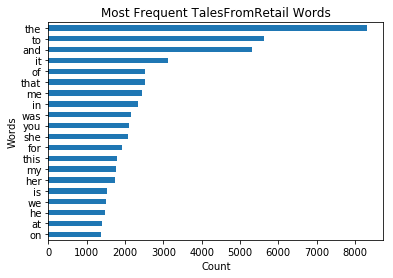

In [18]:
# Show Bar Chart
plt.xlabel('Count')
plt.ylabel('Words')
plt.title('Most Frequent TalesFromRetail Words')
nsw_tfr_body_df.sum().sort_values(ascending = False).head(20).sort_values(ascending = True).plot(kind = 'barh');

Looks like these words are the most common words in the English language and not really helpful in determining the subreddit that they are located in.  We will adjust our Bar Chart using `stop_words`.

#### - TalesFromRetail (w/ StopWords)

In [19]:
# Setup for TalesFromRetail visualization with stop words
sw_cv = CountVectorizer(stop_words= 'english', ngram_range=(1,1))

sw_tfr_body_cv = sw_cv.fit_transform(data[data['subreddit']=='TalesFromRetail']['full_post'])

sw_tfr_body_df = pd.DataFrame(sw_tfr_body_cv.toarray(), columns = sw_cv.get_feature_names())

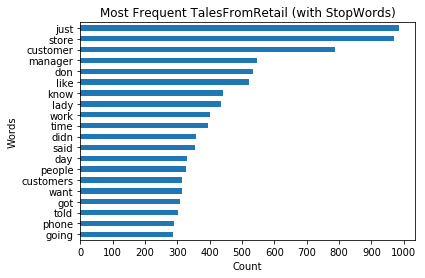

In [20]:
# Show Bar Chart
plt.xlabel('Count')
plt.xticks([0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])
plt.ylabel('Words')
plt.title('Most Frequent TalesFromRetail (with StopWords)')
sw_tfr_body_df.sum().sort_values(ascending = False).head(20).sort_values(ascending = True).plot(kind = 'barh');

These are a more appropriate set of words.  We will continue with `IDontWorkHereLady`.

#### - IDontWorkHereLady

In [21]:
# Setup for IDontWorkHereLady visualization
nsw_cv = CountVectorizer(stop_words= None, ngram_range=(1,1))

nsw_idwhl_body_cv = nsw_cv.fit_transform(data[data['subreddit']=='IDontWorkHereLady']['full_post'])

nsw_idwhl_body_df = pd.DataFrame(nsw_idwhl_body_cv.toarray(), columns = nsw_cv.get_feature_names())

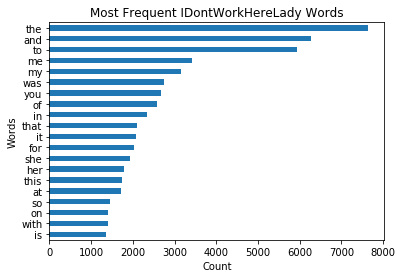

In [22]:
# Show Bar Chart
plt.xlabel('Count')
plt.ylabel('Words')
plt.title('Most Frequent IDontWorkHereLady Words')
nsw_idwhl_body_df.sum().sort_values(ascending = False).head(20).sort_values(ascending = True).plot(kind = 'barh');

Like TalesFromRetail before it, these words are the most common words in the English language, so we will eliminate them using `stop_words`.

#### - IDontWorkHereLady (w/ StopWords)

In [23]:
# Setup for IDontWorkHereLady visualization with stop words
sw_cv = CountVectorizer(stop_words= 'english', ngram_range=(1,1))

sw_idwhl_body_cv = sw_cv.fit_transform(data[data['subreddit']=='IDontWorkHereLady']['full_post'])

sw_idwhl_body_df = pd.DataFrame(sw_idwhl_body_cv.toarray(), columns = sw_cv.get_feature_names())

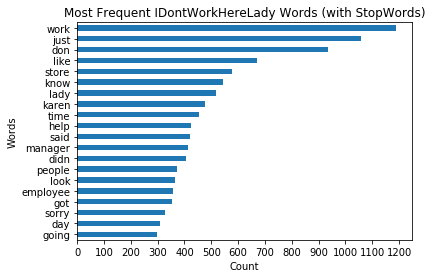

In [24]:
# Show Bar Chart
plt.xlabel('Count')
plt.xticks([0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200])
plt.ylabel('Words')
plt.title('Most Frequent IDontWorkHereLady Words (with StopWords)')
sw_idwhl_body_df.sum().sort_values(ascending = False).head(20).sort_values(ascending = True).plot(kind = 'barh');

These are a more appropriate set of words for `IDontWorkHereLady`.  Of particular interest is the word / name `karen`.  `karen` is a slang term for an antagonistic female character in popular memes. (Source: https://knowyourmeme.com/memes/karen).  This could imply that if `karen` is in your post, the you do not work in retail - thus the post belongs in the IDontWorkHereLady subreddit.  Further analysis is needed.

#### - TalesFromRetail & IDontWorkHereLady (w/ StopWords)

Here we will dig into the most common words that are listed in both TalesFromRetail and IDontWorkHereLady subreddits.  Both subreddits have been filtered out for `stop_words`.

In [25]:
# Creating list of words found in both subreddits
common_words = list(set(sw_tfr_body_df).intersection(set(sw_idwhl_body_df)))

Want to quickly check for `karen` to see if it is exclusively in IDontWorkHereLady.

In [26]:
'karen' in common_words

True

Looks like we cannot imply that `karen` being in a post means that it belongs in IDontWorkHereLady as it is a common word / name in both subreaddits.

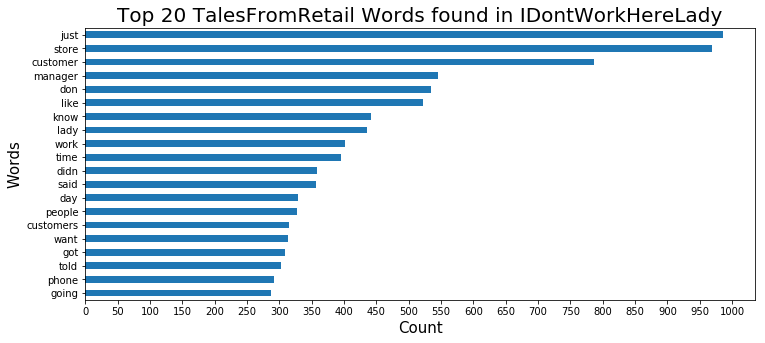

In [27]:
# Bar Chart of TalesFromRetail words found in IDontWorkHere
plt.figure(figsize = (12,5))
plt.ylabel('Words', fontsize = 15)
plt.xlabel('Count', fontsize = 15)
plt.xticks([0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 1050])
plt.title('Top 20 TalesFromRetail Words found in IDontWorkHereLady', fontsize = 20)
sw_tfr_body_df[common_words].sum().sort_values(ascending = True).tail(20).plot(kind = 'barh');

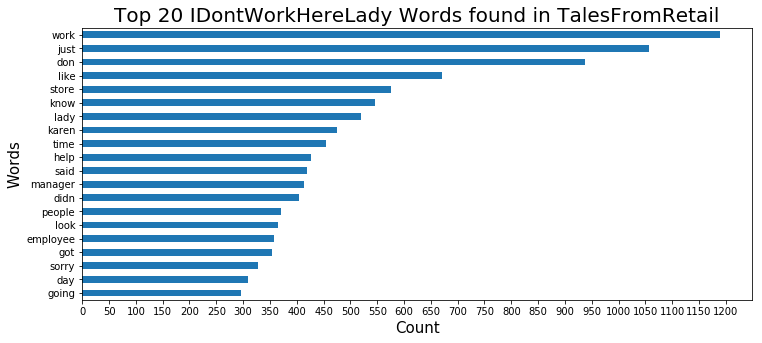

In [28]:
# Bar Chart of IDontWorkHere words found in TalesFromRetail
plt.figure(figsize = (12,5))
plt.ylabel('Words', fontsize = 15)
plt.xlabel('Count', fontsize = 15)
plt.xticks([0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200])
plt.title('Top 20 IDontWorkHereLady Words found in TalesFromRetail', fontsize = 20)
sw_idwhl_body_df[common_words].sum().sort_values(ascending = True).tail(20).plot(kind = 'barh');

We can see that stop words are, overall, imperative in order to properly filter out our data for analyzing as they help filter out 'noise'.

### 03.03. Creating New `stop_words`

We learned in the visualization process that `stop_words` help filter out noise.  We also learned that the `common_words` found in both subreddits ***may not*** be useful for our models.  The thinking is that they would not help in determining where the respective post is sourced from, since the word is not exclusive to any one subreddit.  Based on this logic, we will create a new `frozenset` labeled `english` that adds `common_words` to `english`.

In [29]:
# New stop_word frozenset length should be:
len(english) + len(common_words)

5425

In [30]:
# Combining
new_english = text.ENGLISH_STOP_WORDS.union(common_words)

In [31]:
# length check
len(new_english)

5425

We can use `new_english` in our models to narrow down the features, and (hopefully) accurately predict where a post was made, given the remaining words in each respective post.  This will inform us if our previous line of though was vaild or not.

## 04. Preprocessing Data
---

In this section, we will set up our data for model processing which includes converting the subreddit names into more model-friendly `0` & `1` values and spliting into training and testing data.

In [32]:
data = pd.read_csv('../datasets/combined.csv')

In [33]:
# Checking total amount of posts per subreddit
data['subreddit'].value_counts()

IDontWorkHereLady    446
TalesFromRetail      446
Name: subreddit, dtype: int64

In [34]:
# Changing subreddits to numerical values
data['subreddit'] = data['subreddit'].map({'TalesFromRetail': int(0),
                                           'IDontWorkHereLady': int(1)})

In [35]:
# Checking value counts (as percentage) for both subreddits
data['subreddit'].value_counts(normalize = True)

1    0.5
0    0.5
Name: subreddit, dtype: float64

In [36]:
# Setting up X, y data for modeling
X = data['full_post']
y = data['subreddit']

In [37]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify = y)

## 05. Modeling
---

### 05.01. Baseline Model

In [38]:
# Use for baseline model
y_test.value_counts(normalize=True)

1    0.502242
0    0.497758
Name: subreddit, dtype: float64

Given the above split of the aforementioned subreddits being 50/50 - and that carrying on to our y_test data (`stratify`), we will use this as our baseline model. Our interpretation is that a good model will beat the baseline of 0.5.

We will leverage `pipeline` in order to iterate through multiple potential 'best' models and analyze the results.

### 05.02. Pipeline

For this section we will work on implementing `Pipeline` in order to facilitate the rapid implementation of multiple models with different parameters.  We will use `Pipeline` to implement ContVectorizer and TFIDFVectorizer as tranformers and use Logistic Regression, Multinomial NB and Gaussian NB as our models.  We will continously iterate through various hyperparameters in order to get the best possible score for our model.

#### - Logistic Regression (CountVectorizer)

Because our dependent variable is binary in nature (`0` or `1` as in "is this specific word/ combination of words in this post, yes or no (`1` or `0`), we will impliment Logistic Regression to see if our Baseline Model can be beat.  CountVectorizer will breakdown each post into individual words / features for this process.

In [39]:
# Define cvec Pipeline
pipe = Pipeline(steps = [('cvec', CountVectorizer()),
                         ('model', LogisticRegression())])

# Construct Grid Parameters
hyperparams = {
    'cvec__max_features': [1_000, 5_000, 10_000],
    'cvec__stop_words':  [None, 'english', new_english],
    'cvec__ngram_range': [(1, 2), (1, 1), (2, 2)],
    'model__penalty': ['l1', 'l2']}

# Perform Grid Search
cvec_gs = GridSearchCV(pipe,
                       param_grid = hyperparams,
                       cv = 5,
                       verbose = 3,
                       n_jobs = -1)

cvec_gs.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:   47.1s finished
C:\Users\Fausto\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                            

In [40]:
# Get Scores
cvec_train_score = cvec_gs.score(X_train, y_train)
print('Best train data accuracy for Logistic Regression using CountVectorizer: {:.4f}'.format(cvec_train_score))
cvec_test_score = cvec_gs.score(X_test, y_test)
print('Best test data accuracy for Logistic Regression using CountVectorizer: {:.4f}'.format(cvec_test_score))

Best train data accuracy for Logistic Regression using CountVectorizer: 1.0000
Best test data accuracy for Logistic Regression using CountVectorizer: 0.9148


In [41]:
# Getting best parameters
cvec_gs.best_params_

{'cvec__max_features': 5000,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': None,
 'model__penalty': 'l2'}

Through various iterations, we noticed that the best parameters for this model changed.  For example, we started with `cvec__max_features` as 100, 1,000, and 10,000 to cast a wide net.  In the end, the best `cvec__ngram_range` was (1, 2) (which remained throughout various `pipeline` iterations) and `cvec__stop_words` was (interestingly enough) None and `model_penalty` was l1.  As we isolated the `cveec__max_features` the stop words and penalty changed into, eventually, what we have above, with a train `best_score_` of 1.0000 and our test `best_score_` of 0.9238 - meaning two things:
1. that our training model was overfit and
2. that our test model has a 92% accuracy in predicting which subreddit our `full_post` was sourced from.

#### - Multinomial Naive Bayes

Because out features are variables that take on only positive integer counts (i.e. there are no negative word counts in a post), we will use the MultinomialNB model to see if it outperforms our Baseline.

In [42]:
# Define cvec Pipeline
pipe = Pipeline(steps = [('cvec', CountVectorizer()),
                         ('model', MultinomialNB())])

# Construct Grid Parameters
hyperparams = {
    'cvec__max_features': [5_000, 10_000, 15_000],
    'cvec__stop_words':  [None, 'english', new_english],
    'cvec__ngram_range': [(1, 2), (1, 1), (2, 2)]}

# Perform Grid Search
cvec_gs = GridSearchCV(pipe,
                       param_grid = hyperparams,
                       cv = 5,
                       verbose = 3,
                       n_jobs = -1)

cvec_gs.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:   20.8s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                            

In [43]:
# Get Scores
cvec_train_score = cvec_gs.score(X_train, y_train)
print('Best train data accuracy for MultinomialNB Model: {:.4f}'.format(cvec_train_score))
cvec_test_score = cvec_gs.score(X_test, y_test)
print('Best test data accuracy for MultinomialNB Model: {:.4f}'.format(cvec_test_score))

Best train data accuracy for MultinomialNB Model: 0.9970
Best test data accuracy for MultinomialNB Model: 0.9686


In [44]:
# cvec_gs.best_params_

Our best parameters for Multinomial NB is as follows:
- 'cvec__max_features': 10000,
- 'cvec__ngram_range': (1, 1),
- 'cvec__stop_words': my stopword list named 'new_english'

The reason we are not returning the output of `cvec_gs.best_params_` is because the stopword list itself prints out and not the variable name that was given to it.

It looks like Multinomial has a set of different `best_params_` than the LogReg (CVec) model - ultimately performing better with a train score of 0.9940 and a test score of 0.9641.

#### - Logistic Regression (TFIDFVectorizer)

Because our dependent variable is binary in nature (`0` or `1` as in "is this specific word/ combination of words in this post, yes or no (`1` or `0`), we will impliment Logistic Regression to see if our Baseline Model can be beat.  TFIDFVectorizer will breakdown each post into individual words / features AND it will assign values for each word depended on its frequency - the rarer the word, the better.

In [45]:
# Define tvec Pipeline
pipe = Pipeline(steps = [('tvec', TfidfVectorizer()),
                         ('model', LogisticRegression())])

# Construct Grid Parameters
hyperparams = {
    'tvec__max_features': [10_000, 15_000, 20_000],
    'tvec__stop_words':  [None, 'english', new_english],
    'tvec__ngram_range': [(1, 2), (1, 1), (2, 2)],
    'model__penalty': ['l1', 'l2']}

# Perform Grid Search
tvec_gs = GridSearchCV(pipe,
                       param_grid = hyperparams,
                       cv = 5,
                       verbose = 3,
                       n_jobs = -1)

tvec_gs.fit(X_train,y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:   41.5s finished
C:\Users\Fausto\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tvec',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                          

In [46]:
# Get Scores
tvec_train_score = tvec_gs.score(X_train,y_train)
print('Best train data accuracy for Logistic Regression using TFIDFVectorizer: {:.4f}'.format(tvec_train_score))
tvec_test_score = tvec_gs.score(X_test, y_test)
print('Best test data accuracy for Logistic Regression using TFIDFVectorizer: {:.4f}'.format(tvec_test_score))

Best train data accuracy for Logistic Regression using TFIDFVectorizer: 0.9985
Best test data accuracy for Logistic Regression using TFIDFVectorizer: 0.9462


In [47]:
# tvec_gs.best_params_

Our best parameters for the TFIDFVectorizer pipeline was the following:
- 'model__penalty': 'l2',
- 'tvec__max_features': 15000,
- 'tvec__ngram_range': (1, 2),
- 'tvec__stop_words': my stopword list named 'new_english'

The reason we are not returning the output of `tvec_gs.best_params_` is because the stopword list itself prints out and not the variable name that was given to it.

As with the MultinomialNB model, we have a set of different `best_params_`, which resulted in a train score of 0.9985 and test score of 0.9462.  While ovefit, it is not as severe as the LogReg (CVec)'s overfitting.

#### - Gaussian Naive Bayes

Because TFIDFVectorizer penalizes common words and rewards rare words, the distribution of words is somewhat (but not completely) normalized.  Becuase of this, we will use the GaussianNB model to see if it outperforms our Baseline (or any other) model.

In order to work witn the GaussianNB model, we need to convert our sparse matrix into a dense matrix.

In [48]:
## https://stackoverflow.com/questions/28384680/scikit-learns-pipeline-a-sparse-matrix-was-passed-but-dense-data-is-required
## Transformer class to convert sparse matrix to dense matrix
class DenseTransformer():
    def fit(self, X, y=None, **fit_params):
        return self
    def transform(self, X, y=None, **fit_params):
        return X.todense()

In [49]:
# Define tvec Pipeline
pipe = Pipeline(steps = [('cvec', TfidfVectorizer()),
                         ('dense',DenseTransformer()),
                         ('model', GaussianNB())])

# Construct Grid Parameters
hyperparams = {
    'cvec__max_features': [5_000, 10_000, 15_000],
    'cvec__stop_words':  [None, 'english', new_english],
    'cvec__ngram_range': [(1, 2), (1, 1), (2, 2)]}

# Perform Grid Search
tvec_gs = GridSearchCV(pipe,
                       param_grid = hyperparams,
                       cv = 5,
                       verbose = 3,
                       n_jobs = -1)

tvec_gs.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:   25.6s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                          

In [50]:
# Get Scores
tvec_train_score = tvec_gs.score(X_train, y_train)
print('Best train data accuracy for GaussianNB Model: {:.4f}'.format(tvec_train_score))
tvec_test_score = tvec_gs.score(X_test, y_test)
print('Best test data accuracy for GaussianNB Model: {:.4f}'.format(tvec_test_score))

Best train data accuracy for GaussianNB Model: 0.9970
Best test data accuracy for GaussianNB Model: 0.9686


In [51]:
# tvec_gs.best_params_

Our best parameters for the TFIDFVectorizer pipeline was the following:
- 'tvec__max_features': 10000,
- 'tvec__ngram_range': (1, 1),
- 'tvec__stop_words': my stopword list named 'new_english'

The reason we are not returning the output of `tvec_gs.best_params_` is because the stopword list itself prints out and not the variable name that was given to it.

### 05.03. Modeling Conclusion

Let's take a look at the results of all models simultaneously.

In [52]:
# initialize list of lists 
data = [[0.5000, 0.5000],
        [1.0000, 0.9238],
        [0.9940, 0.9641],
        [0.9985, 0.9462],
        [0.9985, 0.9731]] 
  
# Create the pandas DataFrame 
df = pd.DataFrame(data,
                  columns = ['Train Score', 'Test Score'],
                  index = ['Baseline', 'LogReg (CVec)', 'MultinomialNB', 'LogReg (TFIDFVec)', 'GaussianNB']) 
  
# print dataframe. 
df 

,Train Score,Test Score
Baseline,0.5000,0.5000
LogReg (CVec),1.0000,0.9238
MultinomialNB,0.9940,0.9641
LogReg (TFIDFVec),0.9985,0.9462
GaussianNB,0.9985,0.9731


After gathering, cleaning and performing some exploratory analysis, we were able to transform and fit our data in 5 seperate models.  The Baseline score was the from where we began and with each new model implemented, our goal was to beat the baseline (thus concluding that the model would outperform the baseline and predict, more accurately, from which subreddit a post came from.

While all 4 models did out perform the baseline, our best model was **Gaussian Naive Bayes**.  GaussianNB had less of an overfit than all other models and while its training score was somewhat in the middle, it's test score was the highest.  In addition, GaussianNB ahd the smallest difference between its train and test scores (hence the smaller overfit).